In [1]:
# Import modules
import ord_schema
from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2

import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.colors import Normalize
import numpy as np

## Get data 

In [2]:
pb = 'data/baumgartner_C-N.pb'

# Load Dataset message
data = message_helpers.load_message(pb, dataset_pb2.Dataset)

# Ensure dataset validates
valid_output = validations.validate_message(data)

# Convert dataset to pandas dataframe
df = message_helpers.messages_to_dataframe(data.reactions, 
                                           drop_constant_columns=True)

In [3]:
# Check for NaN values
print(f'number of NaN values: {df.isnull().sum().sum()}')

# Show column counts
df.info()

number of NaN values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 29 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   inputs["Electrophile"].components[0].amount.moles.value                          374 non-null    float64
 1   inputs["Internal_Standard"].components[0].amount.mass.value                      374 non-null    float64
 2   inputs["Nucleophile"].components[0].identifiers[0].value                         374 non-null    object 
 3   inputs["Nucleophile"].components[0].identifiers[1].value                         374 non-null    object 
 4   inputs["Nucleophile"].components[0].amount.moles.value                           374 non-null    float64
 5   inputs["Catalyst"].components[0].identifiers[0].value                            374 non-null   

In [4]:
electrophile_mols = """inputs["Electrophile"].components[0].amount.moles.value"""
base_mols = """inputs["Base"].components[0].amount.moles.value"""
df["base_equiv"] = df[base_mols]/df[electrophile_mols]

In [5]:
aniline = df[df["""inputs["Nucleophile"].components[0].identifiers[0].value"""]=="Aniline"]

In [6]:
aniline["""inputs["Catalyst"].components[0].identifiers[0].value"""].value_counts()

cycloPd tBuXPhos 4-Chlorotoluene        36
cycloPd EPhos 4-Chlorotoluene           35
cycloPd tBuBrettPhos 4-Chlorotoluene    32
cycloPd AlPhos 4-Chlorotoluene          28
Name: inputs["Catalyst"].components[0].identifiers[0].value, dtype: int64

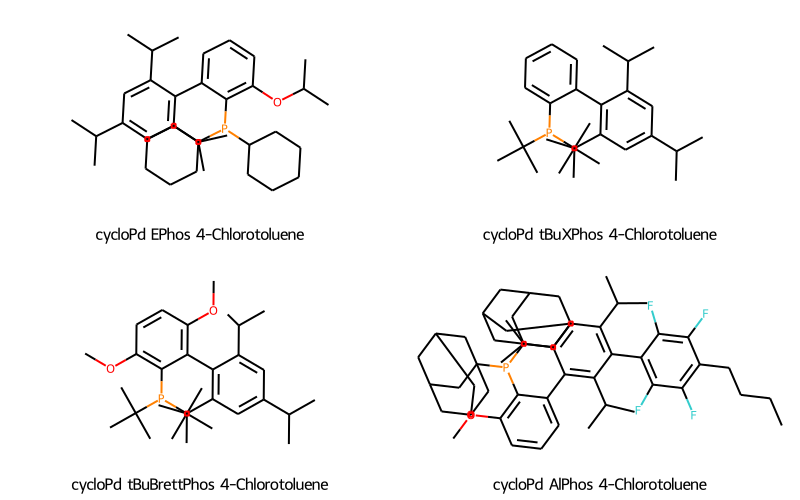

In [7]:
catalyst_names = aniline["""inputs["Catalyst"].components[0].identifiers[0].value"""].unique()
catalyst_smiles = aniline["""inputs["Catalyst"].components[0].identifiers[1].value"""].unique()
catalyst_mols = [Chem.MolFromSmiles(smiles.split(".")[2]) for smiles in catalyst_smiles]
Chem.Draw.MolsToGridImage(
    catalyst_mols,
    molsPerRow=2,
    subImgSize=(400, 250),
    legends=catalyst_names.tolist()
)

In [8]:
# Ignore the preliminary experiments
aniline = aniline[aniline["""inputs["Catalyst"].components[0].identifiers[0].value"""]!="cycloPd EPhos 4-Chlorotoluene"]

In [9]:
cols= {
    'inputs["Catalyst"].components[0].identifiers[0].value': "catalyst",
    'inputs["Base"].components[0].identifiers[0].value': "base",
    'inputs["Solvent"].components[0].identifiers[0].value': "solvent",
    'inputs["Nucleophile"].components[0].identifiers[0].value': "nucleophile",
    'outcomes[0].reaction_time.value': "t_res",
    'conditions.temperature.setpoint.value': "temp",
    'outcomes[0].products[0].measurements[0].percentage.value': "yield",
}
aniline = aniline.rename(columns=cols)

In [10]:
catalysts = {
    "cycloPd tBuXPhos 4-Chlorotoluene": "P1",
    "cycloPd tBuBrettPhos 4-Chlorotoluene": "P2",
    "cycloPd AlPhos 4-Chlorotoluene": "P3"
}
for name, repl in catalysts.items():
    aniline["catalyst"] = aniline["catalyst"].str.replace(name, repl)

In [11]:
bases = {
    "TEA": "B1",
    r"^TMG": "B2",
    r"^BTMG": "B3",
    "DBU": "B4"
}
for name, repl in bases.items():
    aniline["base"] = aniline["base"].str.replace(name, repl, regex=True)

In [12]:
aniline["base"].value_counts()

B2    27
B3    25
B4    24
B1    20
Name: base, dtype: int64

## Best Catalyst

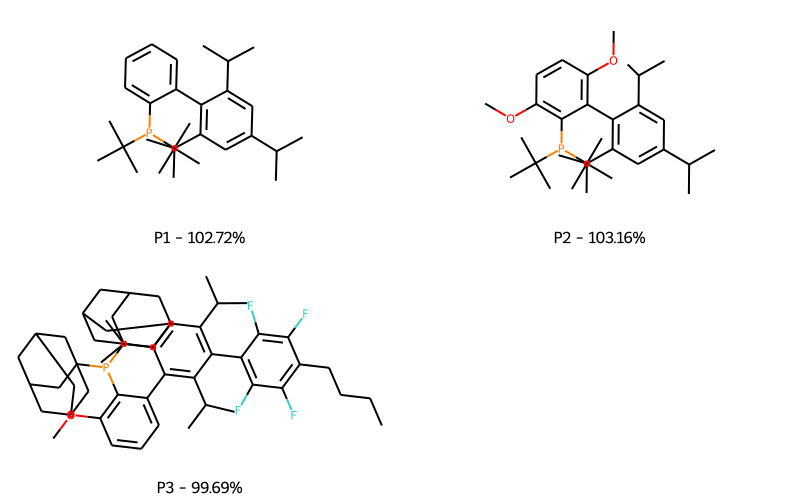

In [21]:
catalyst_names = aniline["catalyst"].unique()
yld_max =  aniline.groupby("catalyst").max()["yield"]
yld_means = aniline.groupby("catalyst").mean()["yield"]
yld_stds = aniline.groupby("catalyst").std()["yield"]
# labels = [
#     f"{name} - {yld_mean:.02f}±{yld_std:0.1f}%" 
#     for name, yld_mean, yld_std in zip(catalyst_names, yld_means, yld_stds)
# ]
labels = [
    f"{name} - {yld_max:.02f}%" 
    for name, yld_max in zip(catalyst_names, yld_max)
]
catalyst_smiles = aniline["""inputs["Catalyst"].components[0].identifiers[1].value"""].unique()
catalyst_mols = [Chem.MolFromSmiles(smiles.split(".")[2]) for smiles in catalyst_smiles]
Chem.Draw.MolsToGridImage(
    catalyst_mols,
    molsPerRow=2,
    subImgSize=(400, 250),
    legends=labels
)

## Parallel coordinates

Based on this: https://stackoverflow.com/questions/8230638/parallel-coordinates-plot-in-matplotlib

In [13]:
def parallel_plot(
    data: pd.DataFrame,
    color_column:str, 
    categorical_columns: str
):
    ynames = data.columns.tolist()
    ynames.remove(color_column)
    data_orig = data.copy()
    # Replace categorical variables
    for col in categorical_columns + [color_column]:
        unique = {v: i for i,v in enumerate(data[col].unique())}
        data = data.replace(unique)
    
    ys = data.drop(color_column, axis=1).to_numpy()
    ymins = ys.min(axis=0)
    ymaxs = ys.max(axis=0)
    dys = ymaxs - ymins
    ymins -= dys * 0.05  # add 5% padding below and above
    ymaxs += dys * 0.05

    ymaxs[1], ymins[1] = ymins[1], ymaxs[1]  # reverse axis 1 to have less crossings
    dys = ymaxs - ymins

    # transform all data to be compatible with the main axis
    zs = np.zeros_like(ys)
    zs[:, 0] = ys[:, 0]
    zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

    fig, host = plt.subplots(figsize=(10,4))

    axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
    for i, ax in enumerate(axes):
        ax.set_ylim(ymins[i], ymaxs[i])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax != host:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('right')
            ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

    host.set_xlim(0, ys.shape[1] - 1)
    host.set_xticks(range(ys.shape[1]))
    host.set_xticklabels(ynames, fontsize=14)
    host.tick_params(axis='x', which='major', pad=7)
    host.spines['right'].set_visible(False)
    host.xaxis.tick_top()
    # host.set_title('Parallel Coordinates Plot — Iris', fontsize=18, pad=12)

    colors = plt.cm.Set2.colors
    targets = data[color_column].tolist()
    legend_handles = [None for _ in targets]
    for j in range(ys.shape[0]):
        # create bezier curves
        verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                         np.repeat(zs[j, :], 3)[1:-1]))
        codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=2, alpha=0.9, edgecolor=colors[targets[j]])
        legend_handles[targets[j]] = patch
        host.add_patch(patch)
    names = data_orig[color_column].unique()
    host.legend(legend_handles, names,
                loc='lower center', bbox_to_anchor=(0.5, -0.18),
                ncol=len(names), fancybox=True, shadow=True)
    return fig, host

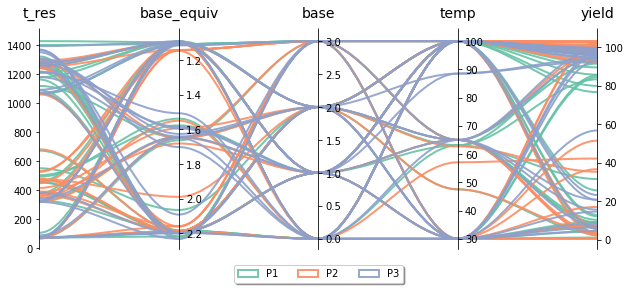

In [14]:
cols = ["t_res", "base_equiv", "base",   "temp",  "yield", "catalyst"]
fig, host = parallel_plot(aniline[cols], color_column="catalyst", categorical_columns=["base"])
fig.savefig("figures/baumgartner_parallel_coordinates.png", dpi=300)

## Christensen Plot

In [13]:
aniline["t_res_min"] = aniline["t_res"] / 60

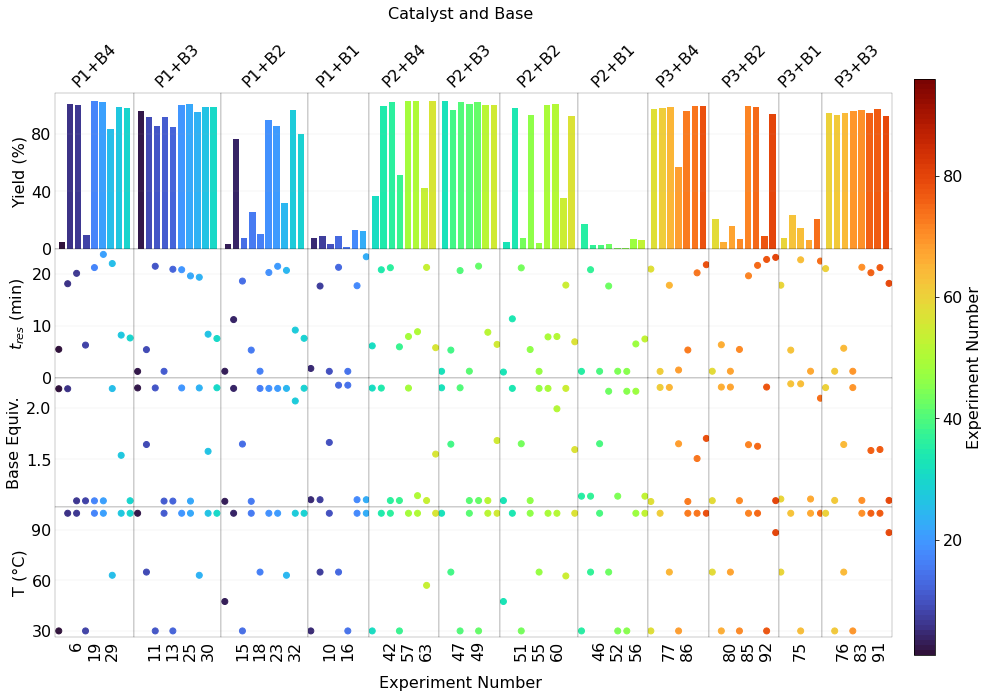

In [28]:
combos = aniline[["catalyst", "base"]].drop_duplicates().reset_index(drop=True)
cont_cols = ["t_res_min", "base_equiv", "temp"]

# Get subsets by categorical variables
subsets = [
    aniline[(aniline["catalyst"]==combo[0]) & (aniline["base"]==combo[1])]
    for _, combo in combos.iterrows()
]
subset_sizes = [subset.shape[0] for subset in subsets]
mss = min(subset_sizes)
width_ratios = [s//mss for s in subset_sizes]

# Setup plot
fig, axes = plt.subplots(
    nrows=len(cont_cols)+1, 
    ncols=combos.shape[0],
    gridspec_kw={
        "width_ratios": subset_sizes,
        "height_ratios": [1.2] + [1]*len(cont_cols)
    },
    figsize=(15,10)
)
fig.subplots_adjust(wspace=0,hspace=0)
N = aniline.shape[0]
start = aniline.index[0]
cmap = plt.get_cmap("turbo", int(1.2*N))
fontsize = 16

# Yields by categorical combo
for i, combo in combos.iterrows():
    ax = axes[0,i]
    colors = cmap((subsets[i].index - start).to_numpy())
    ax.bar(np.arange(0, len(subsets[i])), subsets[i]["yield"], color=colors)
    if i> 0:
        ax.set_yticks([])
        ax1 = axes[0,0]
        ax1.get_shared_y_axes().join(ax1, ax)
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Yield (%)", fontsize=fontsize)
    ax.set_title(f"{combo[0]}+{combo[1]}", rotation=45, fontdict={"fontsize": fontsize})
    # ax.set_xticks([])
    for side in ["left", "top", "bottom", "right"]:
        ax.spines[side].set_linewidth(0.2)
    ax.tick_params(length=0, labelsize=fontsize)
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.grid(axis="y", which="major", linewidth=0.1)
    

# Continuous data
for i, col in enumerate(cont_cols):
    for j, combo in combos.iterrows():
        ax = axes[i+1,j]
        colors = cmap(subsets[j].index - start)
        

        ax.scatter(np.arange(0, len(subsets[j])), subsets[j][col], c=colors)
        if j> 0:
            ax1 = axes[i+1,0]
            ax1.get_shared_y_axes().join(ax1, ax)
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(col, fontsize=fontsize)
        for side in ["left", "bottom", "top", "right"]:
            ax.spines[side].set_linewidth(0.2)
        ax.set_xticks([])
        ax.tick_params(axis="both", length=0.0, labelsize=fontsize)
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        ax.grid(axis="y", which="major", linewidth=0.1) 


# Colorbar
cax = plt.axes([0.92, 0.1, 0.02, 0.8])
norm = Normalize(vmin=1, vmax=N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm,cax=cax,)
cbar.set_label(label="Experiment Number", size=fontsize)
cax.tick_params(labelsize=fontsize)

# Ylabels
ylabels = ["Yield (%)", r"$t_{res}$ (min)", "Base Equiv.", "T (°C)"]
for i,ylabel in enumerate(ylabels):
    axes[i, 0].set_ylabel(ylabel)
    
# Experiment number across bottom
for i, subset in enumerate(subsets):
    ax = axes[-1, i]
    ax.set_xticks(np.arange(0, len(subset)))
    experiment_nums = (subset.index-start).tolist()
    experiment_nums = [
        num if (j%2 == 0 and j!=(len(experiment_nums)-1) and j>0) else None
        for j, num in enumerate(experiment_nums)
    ]
    ax.set_xticklabels(experiment_nums, rotation=90, fontsize=fontsize)
fig.supxlabel("Experiment Number", fontsize=fontsize, y=0.05)
fig.suptitle("Catalyst and Base",y=1.0,fontsize=fontsize,)

fig.savefig("figures/baumgartner_experiments.png", dpi=150)


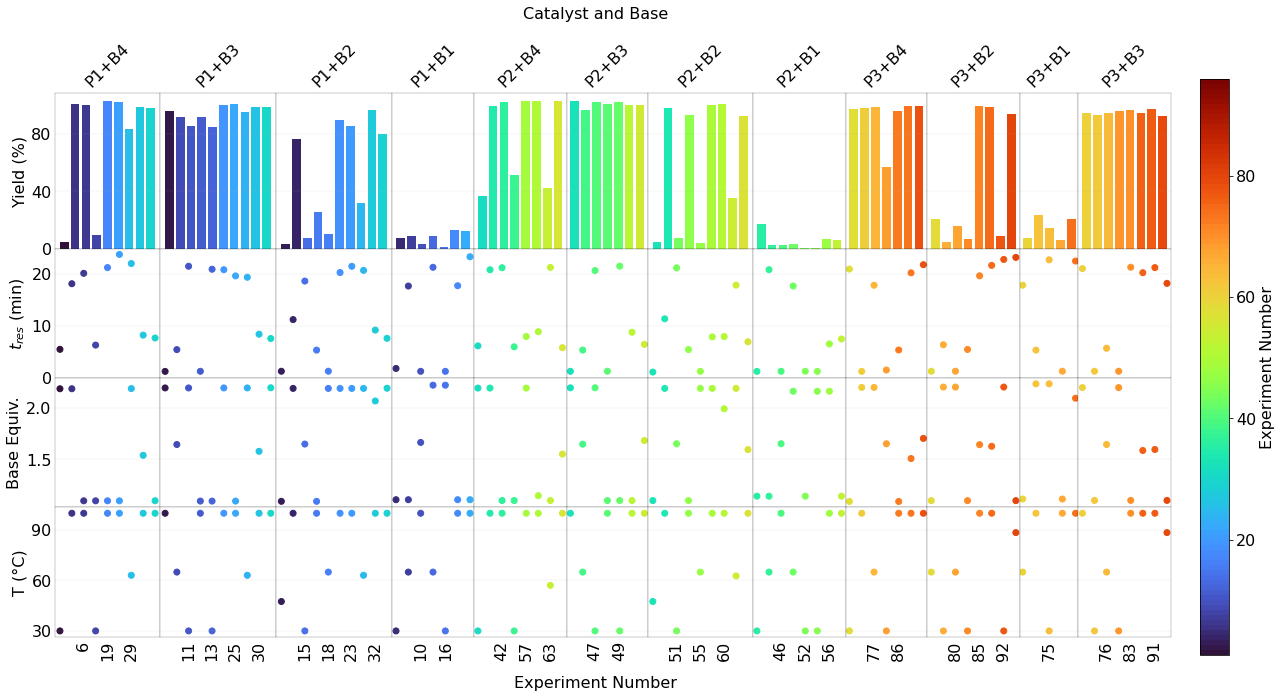

In [19]:
combos = aniline[["catalyst", "base"]].drop_duplicates().reset_index(drop=True)
cont_cols = ["t_res_min", "base_equiv", "temp"]

# Get subsets by categorical variables
subsets = [
    aniline[(aniline["catalyst"]==combo[0]) & (aniline["base"]==combo[1])]
    for _, combo in combos.iterrows()
]
subset_sizes = [subset.shape[0] for subset in subsets]
mss = min(subset_sizes)
width_ratios = [s//mss for s in subset_sizes]

# Setup plot
fig, axes = plt.subplots(
    nrows=len(cont_cols)+1, 
    ncols=combos.shape[0],
    gridspec_kw={
        "width_ratios": subset_sizes,
        "height_ratios": [1.2] + [1]*len(cont_cols)
    },
    figsize=(20,10)
)
fig.subplots_adjust(wspace=0,hspace=0)
N = aniline.shape[0]
start = aniline.index[0]
cmap = plt.get_cmap("turbo", int(1.2*N))
fontsize = 16

# Yields by categorical combo
for i, combo in combos.iterrows():
    ax = axes[0,i]
    colors = cmap((subsets[i].index - start).to_numpy())
    ax.bar(np.arange(0, len(subsets[i])), subsets[i]["yield"], color=colors)
    if i> 0:
        ax.set_yticks([])
        ax1 = axes[0,0]
        ax1.get_shared_y_axes().join(ax1, ax)
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Yield (%)", fontsize=fontsize)
    ax.set_title(f"{combo[0]}+{combo[1]}", rotation=45, fontdict={"fontsize": fontsize})
    # ax.set_xticks([])
    for side in ["left", "top", "bottom", "right"]:
        ax.spines[side].set_linewidth(0.2)
    ax.tick_params(length=0, labelsize=fontsize)
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.grid(axis="y", which="major", linewidth=0.1)
    

# Continuous data
for i, col in enumerate(cont_cols):
    for j, combo in combos.iterrows():
        ax = axes[i+1,j]
        colors = cmap(subsets[j].index - start)
        

        ax.scatter(np.arange(0, len(subsets[j])), subsets[j][col], c=colors)
        if j> 0:
            ax1 = axes[i+1,0]
            ax1.get_shared_y_axes().join(ax1, ax)
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(col, fontsize=fontsize)
        for side in ["left", "bottom", "top", "right"]:
            ax.spines[side].set_linewidth(0.2)
        ax.set_xticks([])
        ax.tick_params(axis="both", length=0.0, labelsize=fontsize)
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        ax.grid(axis="y", which="major", linewidth=0.1) 


# Colorbar
cax = plt.axes([0.92, 0.1, 0.02, 0.8])
norm = Normalize(vmin=1, vmax=N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm,cax=cax,)
cbar.set_label(label="Experiment Number", size=fontsize)
cax.tick_params(labelsize=fontsize)

# Ylabels
ylabels = ["Yield (%)", r"$t_{res}$ (min)", "Base Equiv.", "T (°C)"]
for i,ylabel in enumerate(ylabels):
    axes[i, 0].set_ylabel(ylabel)
    
# Experiment number across bottom
for i, subset in enumerate(subsets):
    ax = axes[-1, i]
    ax.set_xticks(np.arange(0, len(subset)))
    experiment_nums = (subset.index-start).tolist()
    experiment_nums = [
        num if (j%2 == 0 and j!=(len(experiment_nums)-1) and j>0) else None
        for j, num in enumerate(experiment_nums)
    ]
    ax.set_xticklabels(experiment_nums, rotation=90, fontsize=fontsize)
fig.supxlabel("Experiment Number", fontsize=fontsize, y=0.05)
fig.suptitle("Catalyst and Base",y=1.0,fontsize=fontsize,)

fig.savefig("figures/baumgartner_experiments_wide.png", dpi=150)
